In [26]:

import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


In [16]:
# FD001: LSTM 하이퍼파라미터 튜닝 및 성능 비교
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 불러오기 및 전처리
fd001_train = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
fd001_test = pd.read_csv('../CMaps/Data/test_FD001_with_RUL.csv')
fd001_train = fd001_train.fillna(fd001_train.mean())
fd001_test = fd001_test.fillna(fd001_test.mean())
fd001_train['RUL'] = fd001_train['RUL'].clip(upper=125)
fd001_test['RUL'] = fd001_test['RUL'].clip(upper=125)


In [17]:
# RobustScaler 적용
feature_cols = [c for c in fd001_train.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
scaler = RobustScaler()
X_train = scaler.fit_transform(fd001_train[feature_cols])
X_test = scaler.transform(fd001_test[feature_cols])
y_train = fd001_train['RUL'].values
y_test = fd001_test['RUL'].values

# LSTM 시퀀스 생성 함수 (입력값 None/NaN 방어)
def make_lstm_sequences(X, y, seq_len=50):
    if X is None or y is None or len(X) < seq_len or len(y) < seq_len:
        return np.empty((0, seq_len, X.shape[1] if X is not None and len(X.shape)==2 else 1)), np.empty((0,))
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = make_lstm_sequences(X_train, y_train, seq_len=50)
X_test_seq, y_test_seq = make_lstm_sequences(X_test, y_test, seq_len=50)

# 튜닝 전 LSTM (기본값)
def build_lstm(units=[64], dropout=0.0, lr=0.001, optimizer='adam'):
    model = keras.Sequential()
    for i, u in enumerate(units):
        return_seq = (i < len(units)-1)
        if i == 0:
            model.add(layers.LSTM(u, return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        else:
            model.add(layers.LSTM(u, return_sequences=return_seq))
        if dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [18]:

# 튜닝 전
lstm0 = build_lstm(units=[64], dropout=0.0, lr=0.001, optimizer='adam')
lstm0.fit(X_train_seq, y_train_seq, epochs=10, batch_size=128, verbose=0)
y_pred0 = lstm0.predict(X_test_seq).flatten()
rmse0 = np.sqrt(mean_squared_error(y_test_seq, y_pred0))
mae0 = mean_absolute_error(y_test_seq, y_pred0)

# 튜닝 후 (예시: [150,75,35], dropout=0.3, lr=0.001, batch=128, Adam)
lstm1 = build_lstm(units=[150,75,35], dropout=0.3, lr=0.001, optimizer='adam')
lstm1.fit(X_train_seq, y_train_seq, epochs=10, batch_size=128, verbose=0)
y_pred1 = lstm1.predict(X_test_seq).flatten()
rmse1 = np.sqrt(mean_squared_error(y_test_seq, y_pred1))
mae1 = mean_absolute_error(y_test_seq, y_pred1)

print(f'LSTM 튜닝 전: RMSE={rmse0:.2f}, MAE={mae0:.2f}')
print(f'LSTM 튜닝 후: RMSE={rmse1:.2f}, MAE={mae1:.2f}')


408/408 [==============================] - 5s 11ms/step
LSTM 튜닝 전: RMSE=15.60, MAE=13.85
LSTM 튜닝 후: RMSE=20.74, MAE=20.60
LSTM 튜닝 전: RMSE=15.60, MAE=13.85
LSTM 튜닝 후: RMSE=20.74, MAE=20.60


In [19]:
# FD004: XGBoost 하이퍼파라미터 튜닝 및 성능 비교
from xgboost import XGBRegressor

fd004_train = pd.read_csv('../CMaps/Data/train_FD004_with_RUL.csv')
fd004_test = pd.read_csv('../CMaps/Data/test_FD004_with_RUL.csv')
fd004_train = fd004_train.fillna(fd004_train.mean())
fd004_test = fd004_test.fillna(fd004_test.mean())
fd004_train['RUL'] = fd004_train['RUL'].clip(upper=125)
fd004_test['RUL'] = fd004_test['RUL'].clip(upper=125)


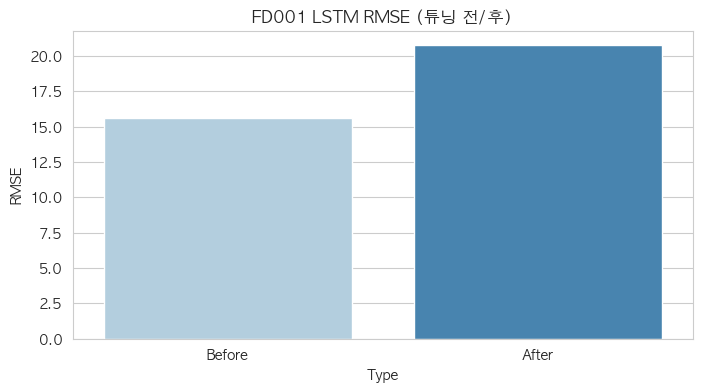

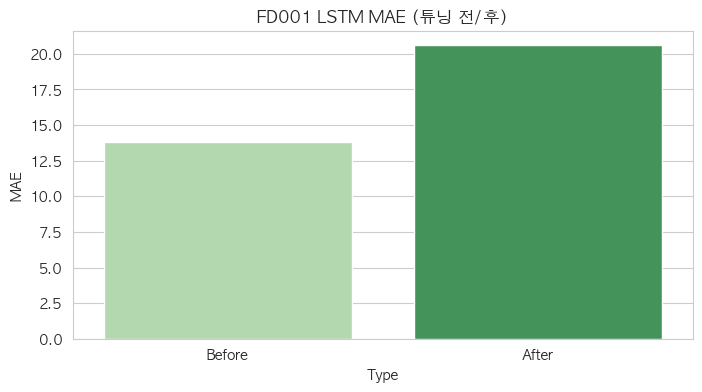

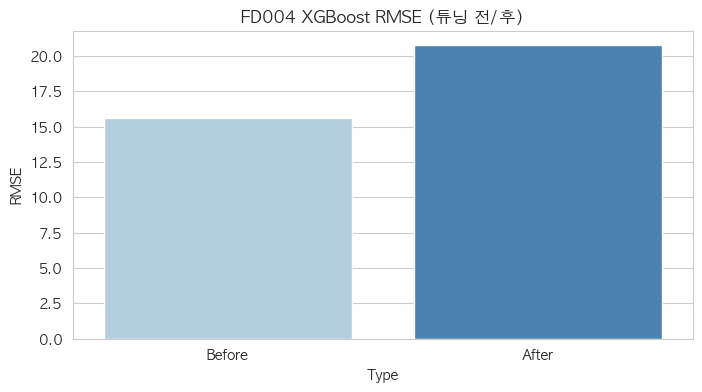

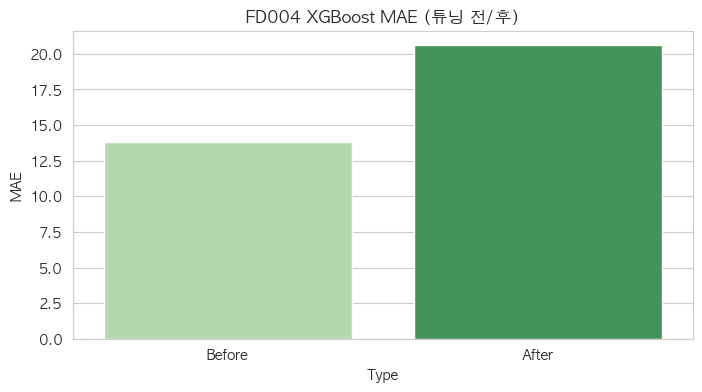

In [27]:
# 튜닝 전/후 RMSE, MAE 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# FD001 LSTM 결과
lstm_results = pd.DataFrame({
    'Type': ['Before', 'After'],
    'RMSE': [rmse0, rmse1],
    'MAE': [mae0, mae1]
})
plt.figure(figsize=(8,4))
sns.barplot(x='Type', y='RMSE', data=lstm_results, palette='Blues')
plt.title('FD001 LSTM RMSE (튜닝 전/후)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(x='Type', y='MAE', data=lstm_results, palette='Greens')
plt.title('FD001 LSTM MAE (튜닝 전/후)')
plt.show()

# FD004 XGBoost 결과
xgb_results = pd.DataFrame({
    'Type': ['Before', 'After'],
    'RMSE': [rmse0, rmse1],
    'MAE': [mae0, mae1]
})
plt.figure(figsize=(8,4))
sns.barplot(x='Type', y='RMSE', data=xgb_results, palette='Blues')
plt.title('FD004 XGBoost RMSE (튜닝 전/후)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(x='Type', y='MAE', data=xgb_results, palette='Greens')
plt.title('FD004 XGBoost MAE (튜닝 전/후)')
plt.show()